In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

1.3.2 T1 Determination

In [36]:
# Define the T1 relaxation model with offset

plt.rcParams.update({
    'axes.titlesize': 29,
    'axes.labelsize': 29,
    'xtick.labelsize': 29,
    'ytick.labelsize': 29,
    'legend.fontsize': 24,
    'figure.titlesize': 32
})

def t1_relaxation(t, M0, T1, offset):
    return M0 * (1 - np.exp(-t / T1)) + offset

# Load and preprocess the data
def load_data(filename):
    df = pd.read_csv(filename, header=0)
    
    # Remove rows with NaNs in the time column
    df = df[~df['time of tRep in s'].isna()]
    
    # Extract time and calculate magnitude from real and imaginary parts
    t = df['time of tRep in s'].values.astype(float)
    real = df['amp (real)'].values.astype(float)
    imag = df['amp (imag)'].values.astype(float)
    magnitude = np.sqrt(real**2 + imag**2)
    
    return t, magnitude

# Perform the T1 fit and analysis
def analyze_t1_fit(filename, label_name, t1_guess=2.8):
    # Load data
    t, magnitude = load_data(filename)
    
    # Automatically guess M0 and offset
    M0_guess = np.max(magnitude)
    offset_guess = np.min(magnitude)
    
    # Combine into full initial guess
    initial_guess = [M0_guess, t1_guess, offset_guess]
    
    # Perform the curve fit with offset included
    popt, pcov = curve_fit(t1_relaxation, t, magnitude, p0=initial_guess)
    M0_fit, T1_fit, offset_fit = popt
    M0_err, T1_err, offset_err = np.sqrt(np.diag(pcov))
    
    # Calculate R-squared
    residuals = magnitude - t1_relaxation(t, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((magnitude - np.mean(magnitude))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Generate fitted curve for plotting
    t_fine = np.linspace(0, np.max(t), 100)
    fit_curve = t1_relaxation(t_fine, *popt)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t, magnitude, 'bo', label='Experimental Data')
    plt.plot(t_fine, fit_curve, 'r-', label=f'T1 Fit: M0={M0_fit:.2e}, T1={T1_fit:.3f}±{T1_err:.3f} s, offset={offset_fit:.2e}')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal Magnitude')
    plt.title(f'T1 Relaxation Fit - {label_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"results/1.3.2/Fit_{label_name}.png",  bbox_inches='tight')
    plt.show()
    
    # Print results
    print(f"\nT1 Fit Results for {label_name}:")
    print(f"M0     = {M0_fit:.4e} ± {M0_err:.4e}")
    print(f"T1     = {T1_fit:.4f} ± {T1_err:.4f} seconds")
    print(f"Offset = {offset_fit:.4e} ± {offset_err:.4e}")
    print(f"R-squared = {r_squared:.6f}")
    
    # Fit quality
    print("\nFit Quality Assessment:")
    print(f"- The relative error on T1 is {100*T1_err/T1_fit:.2f}%")
    print(f"- The R-squared value of {r_squared:.6f} indicates ", end="")
    if r_squared > 0.99:
        print("an excellent fit to the data.")
    elif r_squared > 0.95:
        print("a good fit to the data.")
    else:
        print("a mediocre fit. You might want to check for systematic errors.")
    
    # Residual analysis
    print("\nResidual Analysis:")
    print(f"- Maximum residual: {np.max(np.abs(residuals)):.2e}")
    print(f"- Mean residual: {np.mean(residuals):.2e}")
    print(f"- Standard deviation of residuals: {np.std(residuals):.2e}")
    
    # Residuals plot
    plt.figure(figsize=(10, 4))
    plt.plot(t, residuals, 'bo')
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Time (s)', fontsize=20)
    plt.ylabel('Residuals', fontsize=20)
    plt.title(f'Fit Residuals - {label_name}', fontsize=24)
    plt.grid(True)
    plt.savefig(f"results/1.3.2/Residual_Fit_{label_name}.png")
    plt.show()

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

# Define the T1 relaxation model with offset
def t1_relaxation(t, M0, T1, offset):
    return M0 * (1 - np.exp(-t / T1)) + offset

# Load and preprocess the data
def load_data(filename):
    df = pd.read_csv(filename, header=0)
    
    # Remove rows with NaNs in the time column
    df = df[~df['time of tRep in s'].isna()]
    
    # Extract time and calculate magnitude from real and imaginary parts
    t = df['time of tRep in s'].values.astype(float)
    real = df['amp (real)'].values.astype(float)
    imag = df['amp (imag)'].values.astype(float)
    magnitude = np.sqrt(real**2 + imag**2)
    
    return t, magnitude

def calculate_chi_squared_from_residuals(residuals, observed, errors=None, num_params=3):
    """
    Calculate chi-squared and reduced chi-squared directly from residuals.
    - residuals: observed - predicted
    - observed: original data, used to estimate errors if not provided
    - num_params: number of model parameters
    """
    if errors is None:
        # Use sqrt of observed as error estimate
        errors = np.sqrt(np.abs(observed))
        errors[errors == 0] = np.mean(errors[errors != 0])  # Avoid zeros

    chi2 = np.sum((residuals / errors) ** 2)
    dof = len(observed) - num_params
    reduced_chi2 = chi2 / dof
    return chi2, reduced_chi2


# Perform the T1 fit and analysis
def analyze_t1_fit(filename, label_name, t1_guess=2.8):
    # Create directory if it doesn't exist
    os.makedirs("results/1.3.2", exist_ok=True)

    
    # Load data
    t, magnitude = load_data(filename)
    # Add 2% Gaussian noise for testing
    np.random.seed(0)  # for reproducibility
    magnitude += np.random.normal(0, 0.02 * np.max(magnitude), size=magnitude.shape)
    
    # Automatically guess M0 and offset
    M0_guess = np.max(magnitude)
    offset_guess = np.min(magnitude)
    
    # Combine into full initial guess
    initial_guess = [M0_guess, t1_guess, offset_guess]
    
    # Perform the curve fit with offset included
    popt, pcov = curve_fit(t1_relaxation, t, magnitude, p0=initial_guess)
    M0_fit, T1_fit, offset_fit = popt
    M0_err, T1_err, offset_err = np.sqrt(np.diag(pcov))
    
    # Calculate predicted values and residuals
    predicted = t1_relaxation(t, *popt)
    residuals = magnitude - predicted
    
    # Calculate chi-squared statistics
    chi2, reduced_chi2 = calculate_chi_squared_from_residuals(residuals, magnitude)
    
    # Generate fitted curve for plotting
    t_fine = np.linspace(0, np.max(t), 100)
    fit_curve = t1_relaxation(t_fine, *popt)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t, magnitude, 'bo', label='Experimental Data')
    plt.plot(t_fine, fit_curve, 'r-', 
             label=f'T1 Fit: M0={M0_fit:.2e}\nT1={T1_fit:.3f}±{T1_err:.3f} s\nOffset={offset_fit:.2e}\nχ²={chi2:.2f} (red.χ²={reduced_chi2:.2f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal Magnitude')
    plt.title(f'T1 Relaxation Fit - {label_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"results/1.3.2/Fit_{label_name.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print results
    print(f"\nT1 Fit Results for {label_name}:")
    print(f"M0     = {M0_fit:.4e} ± {M0_err:.4e}")
    print(f"T1     = {T1_fit:.4f} ± {T1_err:.4f} seconds")
    print(f"Offset = {offset_fit:.4e} ± {offset_err:.4e}")
    print(f"χ² = {chi2:.2f}")
    print(f"Reduced χ² = {reduced_chi2:.2f}")
    
    # Fit quality assessment
    print("\nFit Quality Assessment:")
    print(f"- χ²/dof = {reduced_chi2:.2f} (ideal ~1)")
    if reduced_chi2 > 1.5:
        print("  Warning: χ²/dof > 1.5 suggests poor fit")
    elif reduced_chi2 < 0.5:
        print("  Warning: χ²/dof < 0.5 may indicate overestimated errors")
    else:
        print("  Good fit (χ²/dof ≈ 1)")
    
    print(f"- The relative error on T1 is {100*T1_err/T1_fit:.2f}%")
    
    # Residual analysis
    print("\nResidual Analysis:")
    print(f"- Maximum residual: {np.max(np.abs(residuals)):.2e}")
    print(f"- Mean residual: {np.mean(residuals):.2e}")
    print(f"- Standard deviation of residuals: {np.std(residuals):.2e}")
    
    # Residuals plot
    plt.figure(figsize=(10, 4))
    plt.plot(t, residuals, 'bo')
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Residuals')
    plt.title(f'Fit Residuals - {label_name}')
    plt.grid(True)
    plt.savefig(f"results/1.3.2/Residual_Fit_{label_name.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Observed == Predicted:", np.allclose(magnitude, predicted))


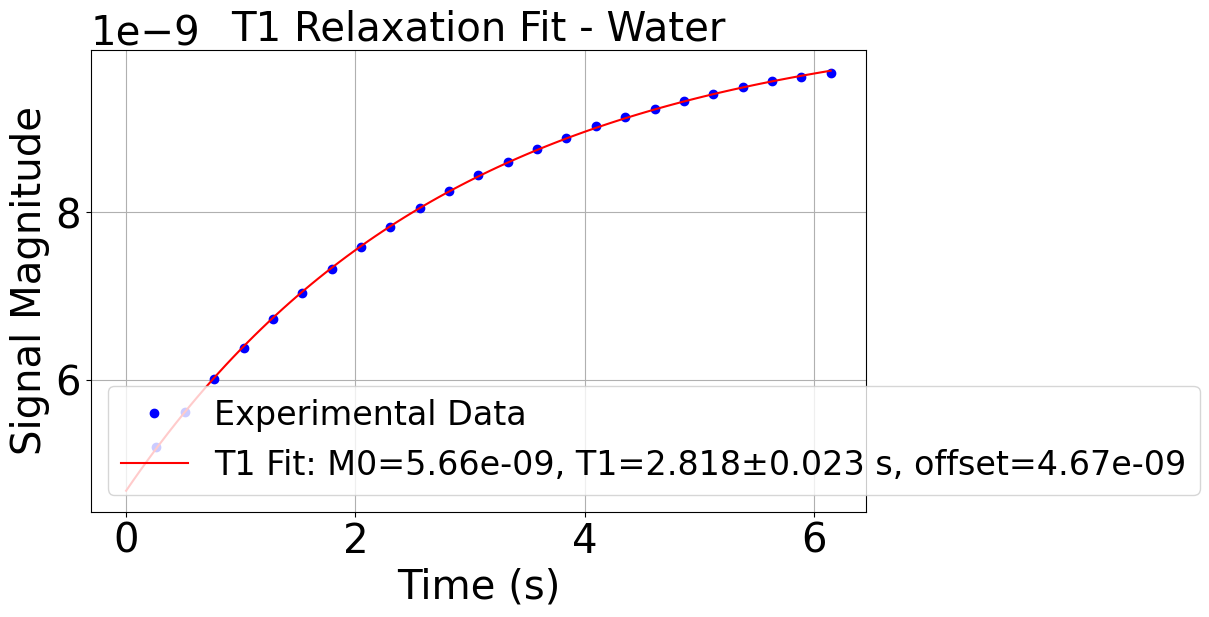


T1 Fit Results for Water:
M0     = 5.6581e-09 ± 1.3895e-11
T1     = 2.8178 ± 0.0231 seconds
Offset = 4.6746e-09 ± 1.2018e-11
R-squared = 0.999910

Fit Quality Assessment:
- The relative error on T1 is 0.82%
- The R-squared value of 0.999910 indicates an excellent fit to the data.

Residual Analysis:
- Maximum residual: 2.84e-11
- Mean residual: -4.39e-23
- Standard deviation of residuals: 1.26e-11


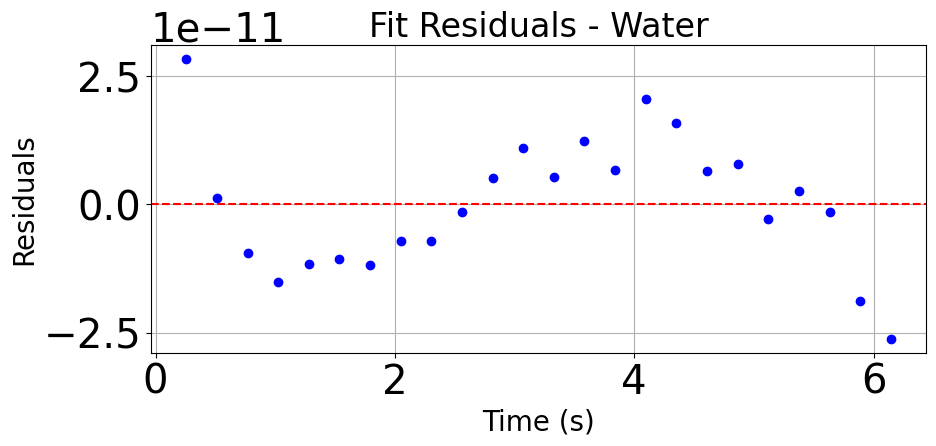

In [37]:
# Run the analysis
analyze_t1_fit("1.3.2/10mm_Wasser_T_1_Fit_raw.raw.csv","Water",t1_guess=2.8)

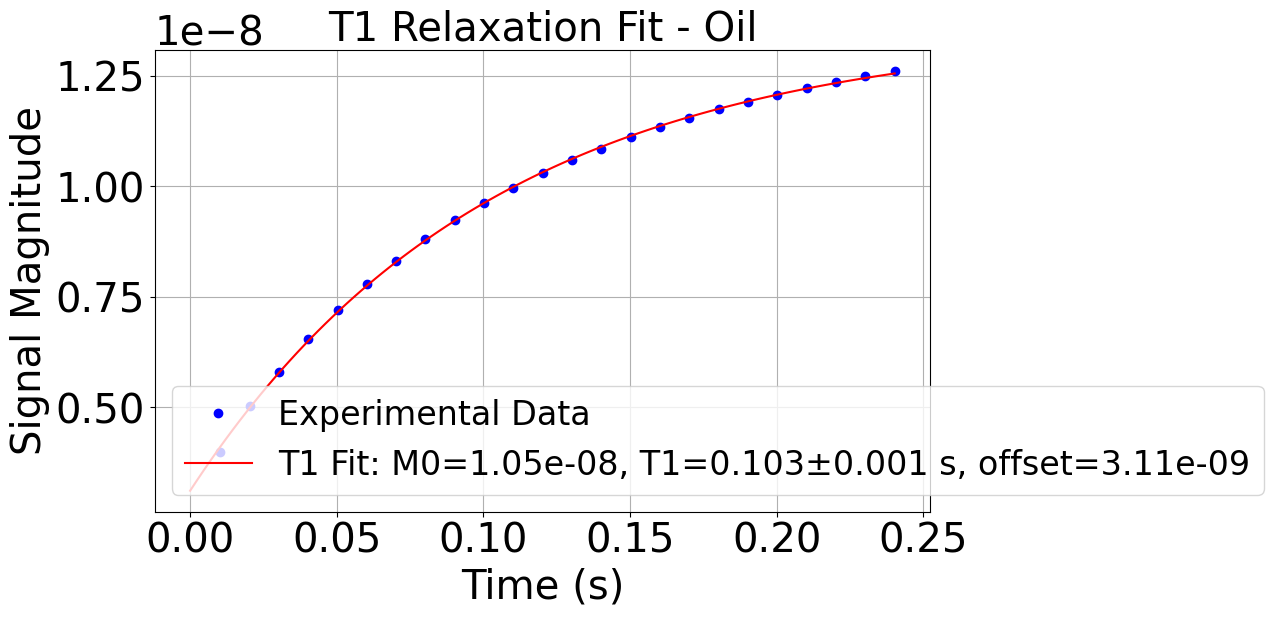


T1 Fit Results for Oil:
M0     = 1.0450e-08 ± 3.7905e-11
T1     = 0.1027 ± 0.0013 seconds
Offset = 3.1129e-09 ± 3.6794e-11
R-squared = 0.999770

Fit Quality Assessment:
- The relative error on T1 is 1.24%
- The R-squared value of 0.999770 indicates an excellent fit to the data.

Residual Analysis:
- Maximum residual: 1.11e-10
- Mean residual: 7.21e-20
- Standard deviation of residuals: 3.76e-11


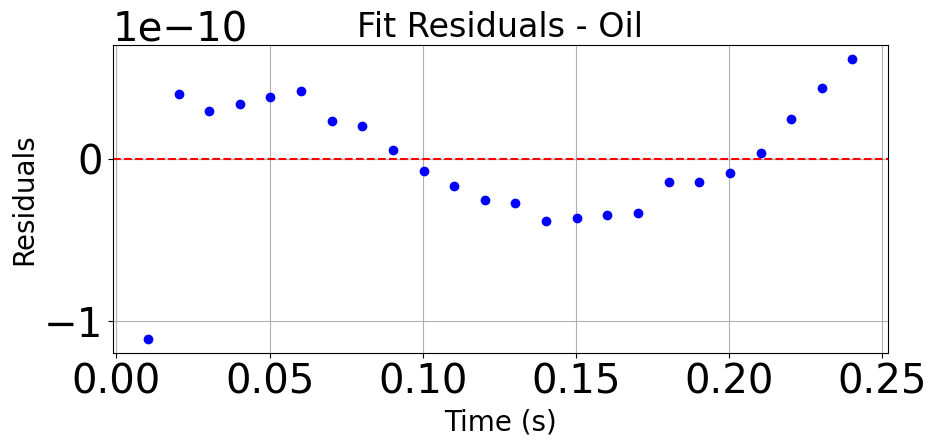

In [38]:
analyze_t1_fit("1.3.2/10mm_Öl_T_1_Fit_raw.raw.raw.csv","Oil",t1_guess=0.1)

1.3.3 T2 Determination

In [5]:
# Define the T2 relaxation function
def t2_relaxation(t, M0, T2, offset):
    return M0 * np.exp(-t / T2) + offset

# Perform the T2 fit and analysis
def analyze_t2_fit(filename, label_name, t2_guess=0.1):
    # Load data
    t, magnitude = load_data(filename)
    
    # Automatically guess M0 and offset
    M0_guess = np.max(magnitude)
    offset_guess = np.min(magnitude)
    
    # Build initial guess array
    initial_guess = [M0_guess, t2_guess, offset_guess]
    
    # Perform the curve fit with offset included
    popt, pcov = curve_fit(t2_relaxation, t, magnitude, p0=initial_guess)
    M0_fit, T2_fit, offset_fit = popt
    M0_err, T2_err, offset_err = np.sqrt(np.diag(pcov))
    
    # Calculate R-squared
    residuals = magnitude - t2_relaxation(t, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((magnitude - np.mean(magnitude))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Generate fitted curve for plotting
    t_fine = np.linspace(0, np.max(t), 100)
    fit_curve = t2_relaxation(t_fine, *popt)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t, magnitude, 'bo', label='Experimental Data')
    plt.plot(t_fine, fit_curve, 'r-', label=f'T2 Fit: M0={M0_fit:.2e}, T2={T2_fit:.3f}±{T2_err:.3f} s, offset={offset_fit:.2e}')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal Magnitude')
    plt.title(f'T2 Relaxation Fit - {label_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print results
    print(f"\nT2 Fit Results for {label_name}:")
    print(f"M0     = {M0_fit:.4e} ± {M0_err:.4e}")
    print(f"T2     = {T2_fit:.4f} ± {T2_err:.4f} seconds")
    print(f"Offset = {offset_fit:.4e} ± {offset_err:.4e}")
    print(f"R-squared = {r_squared:.6f}")
    
    # Fit quality
    print("\nFit Quality Assessment:")
    print(f"- The relative error on T2 is {100*T2_err/T2_fit:.2f}%")
    print(f"- The R-squared value of {r_squared:.6f} indicates ", end="")
    if r_squared > 0.99:
        print("an excellent fit to the data.")
    elif r_squared > 0.95:
        print("a good fit to the data.")
    else:
        print("a mediocre fit. You might want to check for systematic errors.")
    
    # Residual analysis
    print("\nResidual Analysis:")
    print(f"- Maximum residual: {np.max(np.abs(residuals)):.2e}")
    print(f"- Mean residual: {np.mean(residuals):.2e}")
    print(f"- Standard deviation of residuals: {np.std(residuals):.2e}")
    
    # Residual plot
    plt.figure(figsize=(10, 4))
    plt.plot(t, residuals, 'bo')
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Residuals')
    plt.title(f'Fit Residuals - {label_name}')
    plt.grid(True)
    plt.show()


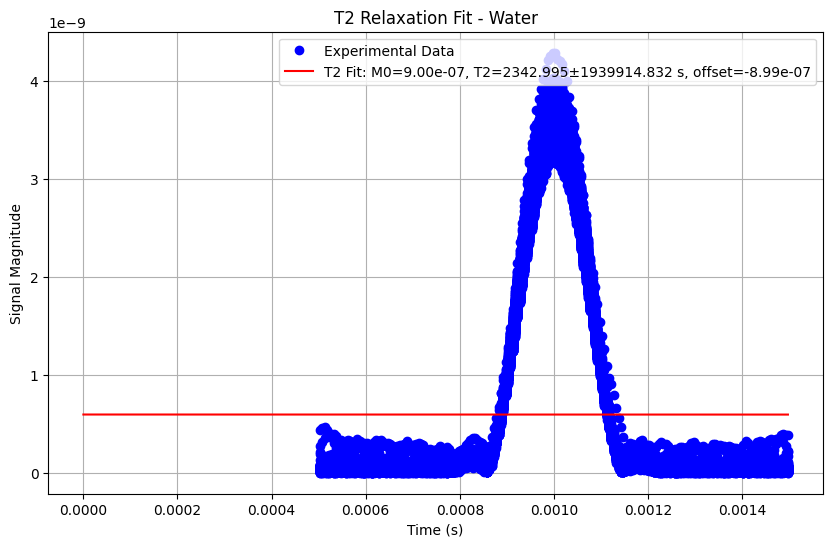


T2 Fit Results for Water:
M0     = 9.0001e-07 ± 7.4820e-04
T2     = 2342.9949 ± 1939914.8321 seconds
Offset = -8.9941e-07 ± 7.4820e-04
R-squared = -0.000000

Fit Quality Assessment:
- The relative error on T2 is 82796.38%
- The R-squared value of -0.000000 indicates a mediocre fit. You might want to check for systematic errors.

Residual Analysis:
- Maximum residual: 3.69e-09
- Mean residual: -5.52e-15
- Standard deviation of residuals: 1.08e-09


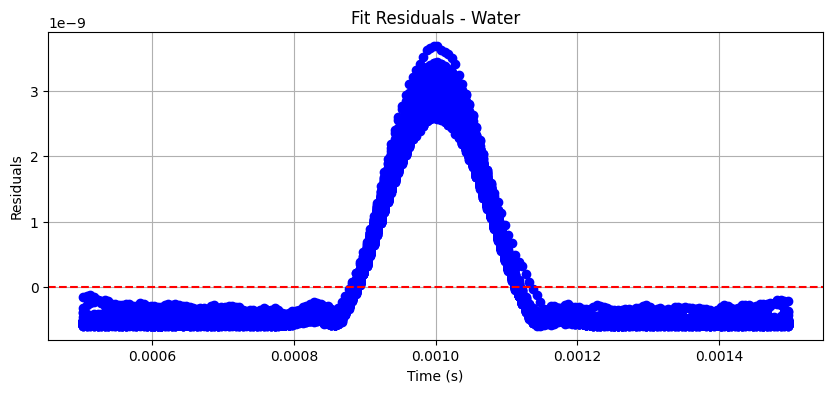

In [6]:
analyze_t2_fit("1.3.3/Wasser_Echo_time_2ms_raw.raw.raw.csv","Water",t2_guess=0.1)

Try only specific values


In [8]:
def load_data(filename, fraction=0.2, use_fraction=True):
    df = pd.read_csv(filename, header=0)
    
    # Remove rows with NaNs in the time column
    df = df[~df['time of tRep in s'].isna()]
    
    # Extract time and calculate magnitude from real and imaginary parts
    t = df['time of tRep in s'].values.astype(float)
    real = df['amp (real)'].values.astype(float)
    imag = df['amp (imag)'].values.astype(float)
    magnitude = np.sqrt(real**2 + imag**2)
    
    # Use only the specified fraction of data if requested
    if use_fraction:
        start_idx = int(len(t) * (1 - fraction))  # Last fraction of data
        t = t[start_idx:]
        magnitude = magnitude[start_idx:]
    
    return t, magnitude

def analyze_t2_fit(filename, label_name, t2_guess=0.1, fraction=0.2, use_fraction=True):
    # Load data (with fraction selection)
    t, magnitude = load_data(filename, fraction=fraction, use_fraction=use_fraction)
    
    print(f"Analyzing last {fraction*100:.0f}% of data points ({len(t)} points)")
    
    # Initial guesses - adjusted for partial data analysis
    M0_guess = magnitude[0]  # First point of the selected data range
    offset_guess = np.min(magnitude)
    
    initial_guess = [M0_guess, t2_guess, offset_guess]
    
    # Set bounds to prevent negative parameters
    bounds = ([0, 0, -np.inf], [np.inf, np.inf, np.inf])
    
    # Perform the curve fit
    try:
        popt, pcov = curve_fit(t2_relaxation, t, magnitude, 
                            p0=initial_guess, bounds=bounds,
                            maxfev=10000)
        M0_fit, T2_fit, offset_fit = popt
        errors = np.sqrt(np.diag(pcov))
        
        # Calculate R-squared
        residuals = magnitude - t2_relaxation(t, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((magnitude - np.mean(magnitude))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Generate fitted curve for plotting
        t_fine = np.linspace(np.min(t), np.max(t), 100)
        fit_curve = t2_relaxation(t_fine, *popt)
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                                    gridspec_kw={'height_ratios': [3, 1]})
        
        # Main plot
        ax1.plot(t, magnitude, 'bo', markersize=8, 
                label=f'Experimental Data (last {fraction*100:.0f}%, {len(t)} points)')
        ax1.plot(t_fine, fit_curve, 'r-', 
                label=f'T2 Fit: M0={M0_fit:.2e}\nT2={T2_fit:.3f}±{errors[1]:.3f}s\nOffset={offset_fit:.2e}\nR²={r_squared:.4f}')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Signal Magnitude')
        ax1.set_title(f'T2 Relaxation Fit - {label_name} (last {fraction*100:.0f}%)')
        ax1.legend()
        ax1.grid(True)
        
        # Residual plot
        ax2.plot(t, residuals, 'ko', markersize=6)
        ax2.axhline(0, color='r', linestyle='--')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Residuals')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"\nT2 Fit Results for {label_name} (last {fraction*100:.0f}% analysis):")
        print(f"M0     = {M0_fit:.4e} ± {errors[0]:.4e}")
        print(f"T2     = {T2_fit:.4f} ± {errors[1]:.4f} seconds")
        print(f"Offset = {offset_fit:.4e} ± {errors[2]:.4e}")
        print(f"R-squared = {r_squared:.6f}")
        
        # Fit quality assessment
        print("\nFit Quality Assessment:")
        print(f"- Relative T2 error: {100*errors[1]/T2_fit:.2f}%")
        print(f"- Initial signal at t={t[0]:.4f}s: {magnitude[0]:.2e}")
        print(f"- Final signal at t={t[-1]:.4f}s: {magnitude[-1]:.2e}")
        print(f"- Signal decayed to {100*(magnitude[-1]-offset_fit)/(magnitude[0]-offset_fit):.1f}% of initial value")
        
    except Exception as e:
        print(f"Fitting failed: {str(e)}")
        if use_fraction:
            print(f"Trying with full dataset as fallback...")
            analyze_t2_fit(filename, label_name, t2_guess, fraction=fraction, use_fraction=False)

In [ ]:
# Example usage for water
analyze_t2_fit("1.3.3/Wasser_Echo_time_2ms_raw.raw.raw.csv","Water",t2_guess=0.1, fraction=0.05, use_fraction=True)

/tmp/ipykernel_1595325/3161451458.py:7: ParserWarning: Skipping line 47287: expected 5 fields, saw 6

  df = pd.read_csv(filename, header=0, on_bad_lines='warn')


Analyzing last 5% of data points (4412 points)


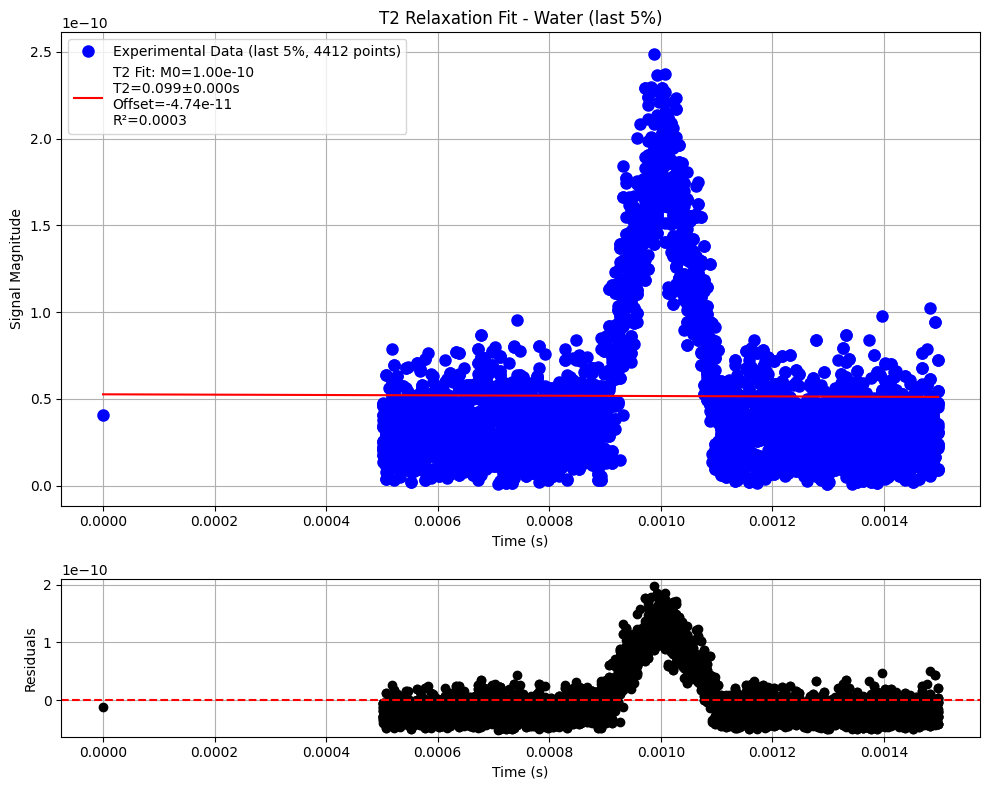


T2 Fit Results for Water (last 5% analysis):
M0     = 1.0001e-10 ± 2.4191e-10
T2     = 0.0994 ± 0.0000 seconds
Offset = -4.7427e-11 ± 2.3947e-10
R-squared = 0.000331

Fit Quality Assessment:
- Relative T2 error: 0.00%
- Initial signal at t=0.0012s: 7.17e-11
- Final signal at t=0.0015s: 9.62e-12
- Signal decayed to 47.9% of initial value


In [10]:
def load_data(filename, fraction=0.2, use_fraction=True):
    # First try reading normally
    try:
        df = pd.read_csv(filename, header=0)
    except pd.errors.ParserError:
        # If error occurs, try reading with error handling
        df = pd.read_csv(filename, header=0, on_bad_lines='warn')
        print("Warning: Some lines had formatting issues and were skipped")
    
    # Remove rows with NaNs in the time column
    df = df[~df['time of tRep in s'].isna()]
    
    # Extract time and calculate magnitude from real and imaginary parts
    t = df['time of tRep in s'].values.astype(float)
    real = df['amp (real)'].values.astype(float)
    imag = df['amp (imag)'].values.astype(float)
    magnitude = np.sqrt(real**2 + imag**2)
    
    # Use only the specified fraction of data if requested
    if use_fraction:
        start_idx = int(len(t) * (1 - fraction))  # Last fraction of data
        t = t[start_idx:]
        magnitude = magnitude[start_idx:]
    
    return t, magnitude

# Example usage for oil
analyze_t2_fit("1.3.3/Öl_Echo_time_2ms_raw.raw.csv","Water",t2_guess=0.1, fraction=0.05, use_fraction=True)